In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/USC/Senior/QBIO\ 465/Final\ Project/QBIO\ 465\ FP/Original /content/
dataset_path = '/content/Original/'

In [ ]:
classes = ['Benign', 'Early', 'Pre', 'Pro']

In [ ]:
data_dir = dataset_path

image_paths = []
labels = []

for cls in classes:
    cls_folder = os.path.join(data_dir, cls)
    if cls == 'Benign':
        folder_to_load = os.path.join(cls_folder, 'augmented')
    else:
        folder_to_load = cls_folder

    for fname in os.listdir(folder_to_load):
        if fname.endswith('.jpg'):
            image_paths.append(os.path.join(folder_to_load, fname))
            labels.append(cls)

In [ ]:
img_size = (224, 224)

def load_images(paths, size):
    images = []
    for path in paths:
        img = Image.open(path).resize(size)
        images.append(np.array(img))
    return np.array(images)

X = load_images(image_paths, img_size)
X = preprocess_input(X.astype('float32'))

le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2921, 224, 224, 3)
Test shape: (731, 224, 224, 3)


In [ ]:
from collections import Counter
print(Counter(labels))

Counter({'Early': 985, 'Pre': 963, 'Benign': 900, 'Pro': 804})


In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping]
)

# # Fine tune model
# for layer in base_model.layers[:-30]:
#     layer.trainable = False
# for layer in base_model.layers[-30:]:
#     layer.trainable = True

# # Recompile the model
# model.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Fine-tune the model
# history = model.fit(
#     X_train, y_train,
#     epochs=10,
#     validation_data=(X_test, y_test),
#     batch_size=32,
# )

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 328ms/step - accuracy: 0.3260 - loss: 1.4704 - val_accuracy: 0.5171 - val_loss: 1.3743
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3488 - loss: 1.4418 - val_accuracy: 0.5349 - val_loss: 1.3468
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3705 - loss: 1.4140 - val_accuracy: 0.5609 - val_loss: 1.3207
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3804 - loss: 1.3812 - val_accuracy: 0.5746 - val_loss: 1.2967
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3839 - loss: 1.3697 - val_accuracy: 0.5964 - val_loss: 1.2736
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4053 - loss: 1.3425 - val_accuracy: 0.6156 - val_loss: 1.2521
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4126 - loss: 1.3246 - val_accuracy: 0.6293 - val_loss: 1.2313
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4086 - loss: 1.3158 - val_accuracy: 

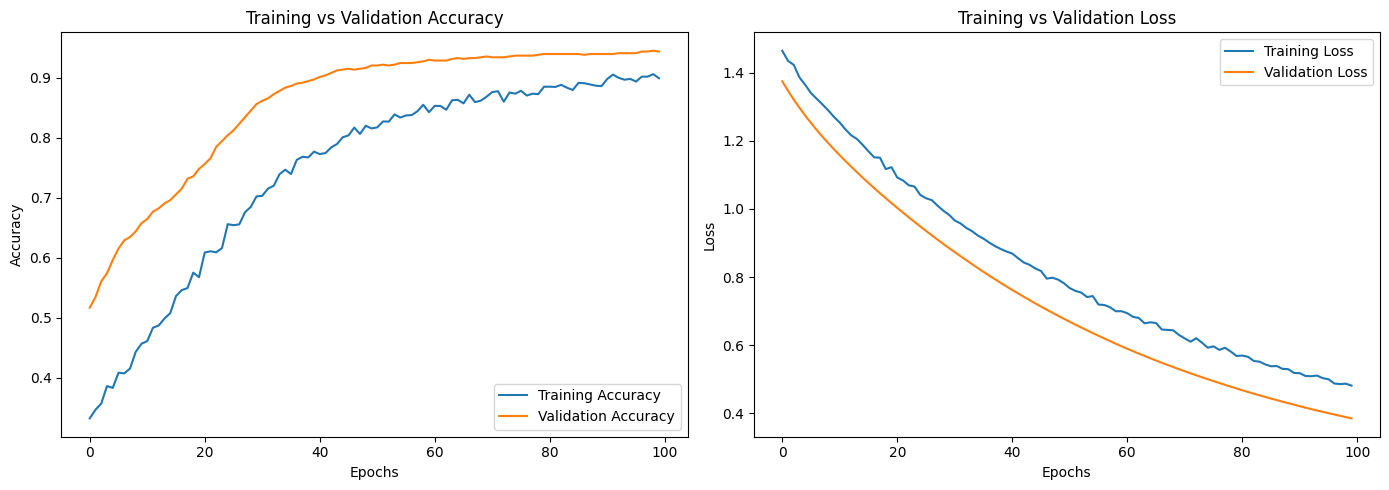

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Fine tune model
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=3,
  restore_best_weights=True
)

# Recompile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 292ms/step - accuracy: 0.5651 - loss: 1.1224 - val_accuracy: 0.9248 - val_loss: 0.4513
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7961 - loss: 0.8349 - val_accuracy: 0.9179 - val_loss: 0.4426
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8753 - loss: 0.6419 - val_accuracy: 0.9330 - val_loss: 0.3580
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9001 - loss: 0.4993 - val_accuracy: 0.9412 - val_loss: 0.2815
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9190 - loss: 0.3981 - val_accuracy: 0.9508 - val_loss: 0.2239
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9360 - loss: 0.3044 - val_accuracy: 0.9562 - val_loss: 0.1797
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9484 - loss: 0.2604 - val_accuracy: 0.9658 - val_loss: 0.1498
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9485 - loss: 0.2215 - val_accuracy: 0.9726 -

In [ ]:
model.save('/content/drive/MyDrive/USC/Senior/QBIO 465/Final Project/QBIO 465 FP/efficientnetb0_model.h5')

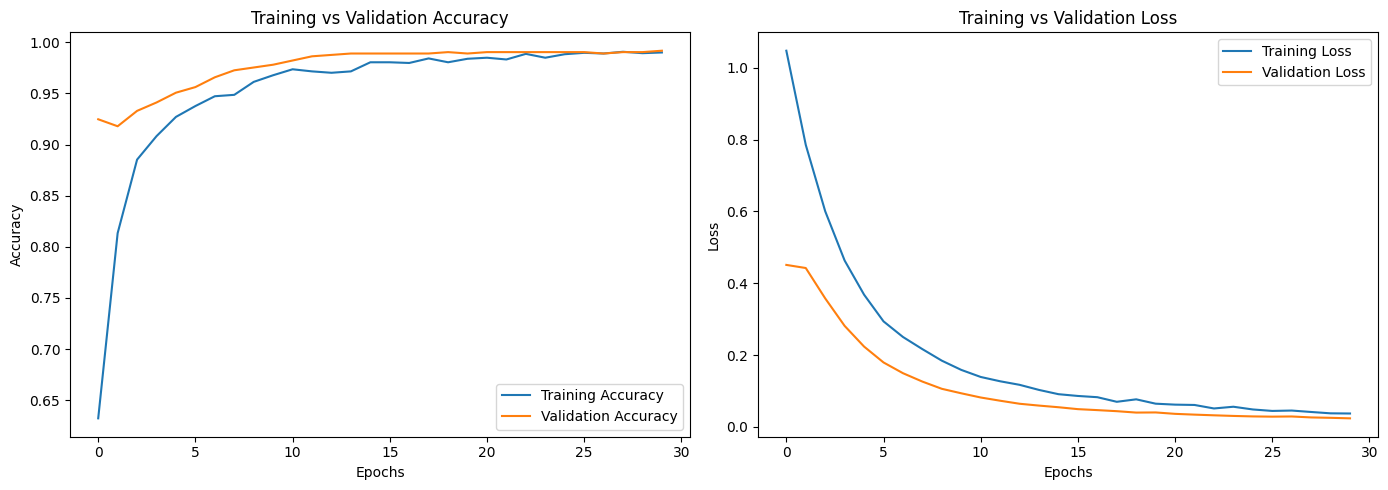

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step
              precision    recall  f1-score   support

      Benign       0.99      0.98      0.99       180
       Early       0.98      1.00      0.99       197
         Pre       1.00      0.99      1.00       193
         Pro       0.99      0.99      0.99       161

    accuracy                           0.99       731
   macro avg       0.99      0.99      0.99       731
weighted avg       0.99      0.99      0.99       731



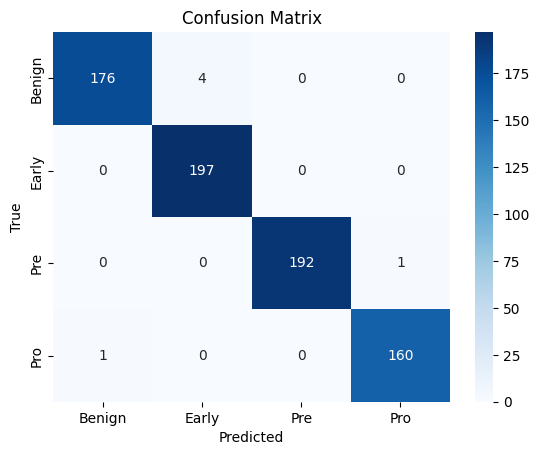

In [ ]:
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('efficientnetb0_confusion_matrix.png', dpi=300)
plt.show()

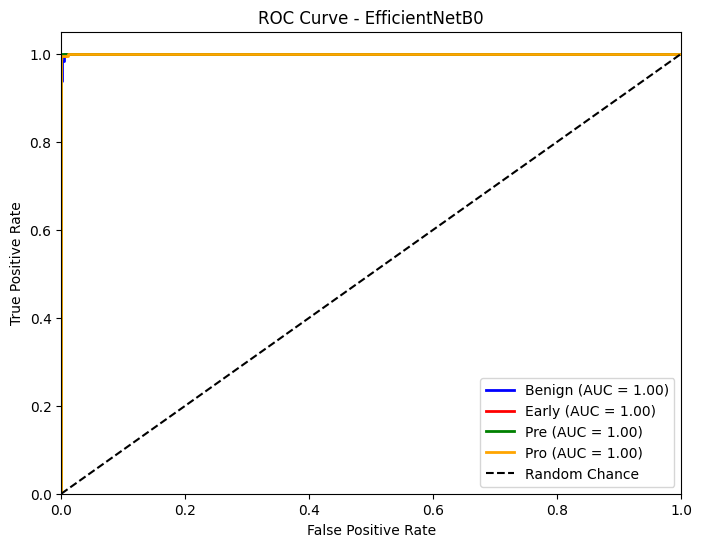

In [ ]:
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNetB0')
plt.legend(loc='lower right')
plt.savefig('efficientnetb0_roc_curve.png', dpi=300)
plt.show()

#Grad-CAM

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from IPython.display import Image, display
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.models import load_model

# model = load_model('efficientnetb0_model.h5')
model.layers[-1].activation = None

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_size = (224, 224)
last_conv_layer_name = 'top_conv'

In [ ]:
"""
Grad-CAM algorithm adapted from : https://keras.io/examples/vision/grad_cam/
"""

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = preprocess_input(array)
    return np.expand_dims(array, axis=0)

# Step 2: Generate heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Step 3: Overlay heatmap on image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path, color_mode="grayscale")
    img = img_to_array(img)
    img = np.repeat(img, 3, axis=-1)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

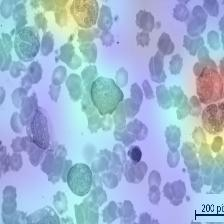

In [ ]:
img_path = '/content/drive/MyDrive/USC/Senior/QBIO 465/Final Project/QBIO 465 FP/Original/Benign/WBC-Benign-461.jpg'

img_array = get_img_array(img_path, img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)

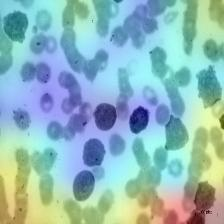

In [ ]:
img_path = '/content/drive/MyDrive/USC/Senior/QBIO 465/Final Project/QBIO 465 FP/Original/Early/WBC-Malignant-Early-737.jpg'

img_array = get_img_array(img_path, img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)

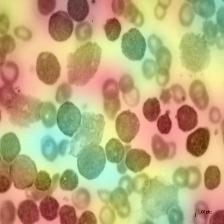

In [ ]:
img_path = '/content/drive/MyDrive/USC/Senior/QBIO 465/Final Project/QBIO 465 FP/Original/Pre/WBC-Malignant-Pre-855.jpg'

img_array = get_img_array(img_path, img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)

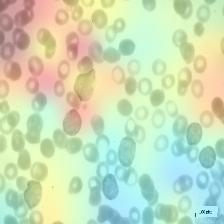

In [ ]:
img_path = '/content/drive/MyDrive/USC/Senior/QBIO 465/Final Project/QBIO 465 FP/Original/Pro/WBC-Malignant-Pro-497.jpg'  # Replace with actual image

img_array = get_img_array(img_path, img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)